In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict
import math

import os
import sys
import scipy.stats

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
# compute propensity 

In [3]:
def compute_svr_entropy(df, seed=0):
    from sklearn import svm, metrics
    from sklearn.utils import shuffle
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline

    X = df["sf"].to_numpy()
    y = df["entropy-binary-opt"]
    max_iter = 100000
    test_size = 0.2

    rng = np.random.default_rng(seed)
    rand_seeds = rng.integers(low=0, high=2**32-1, size=2)

    shuff_y, shuff_X = shuffle(
        y, list(X), random_state=rand_seeds[0])

    X_train, X_test, y_train, y_test = train_test_split(
        shuff_X, shuff_y, test_size=test_size)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', svm.LinearSVR(
            max_iter=max_iter))
    ])

    pipe.fit(X_train, y_train)

    y_predict = pipe.predict(list(df["sf"].to_numpy()))
    return y_predict

In [5]:
for job in project.find_jobs({"replica": 0, "delta": {"$eq": 0.0}}):
    sp = job.sp
    doc = job.doc
    print(job)

    if not "isconfig_fire_ran" in doc:
        print("skipping", job)
        continue

    isos = sorted(glob.glob(job.fn("short_runs/*/fire_isconfig.parquet")))
    descrs = sorted(glob.glob(job.fn("short_runs/*/struct-descr.parquet")))
    sfs = sorted(glob.glob(job.fn("short_runs/temp-*/sfs.parquet")))
    # print(isos)


    # compute mean propensity/phop

    for i in range(len(isos)):
        print(i)
        df = pd.read_parquet(isos[i])
        df2 = pd.read_parquet(descrs[i])
        df3 = pd.read_parquet(sfs[i])

        df = df[(df["frame"] == 0)]
        df2 = df2[df2["frame"] == 0]
        df = df[df["id"].isin(df2["tag"])]
        df3 = df3[(df3["frame"] == 0) & (df3["type"] == 0)]

        df2["sf"] = df3["sf"]

        s1 = df.groupby(["id"]).apply(lambda x: x["prop"].mean())

        predict = compute_svr_entropy(df2)
        df2["svr-entropy"] = predict
        df2["prop"] = s1

        output = isos[i].replace("fire_isconfig", "fire_isconfig_corr")
        assert output != isos[i]

        df2.iloc[:,[4,5,6,7,10,11]].corr().to_parquet(output)

1fd668d1992cea34bb8de5b9cf4bc990
0


KeyboardInterrupt: 

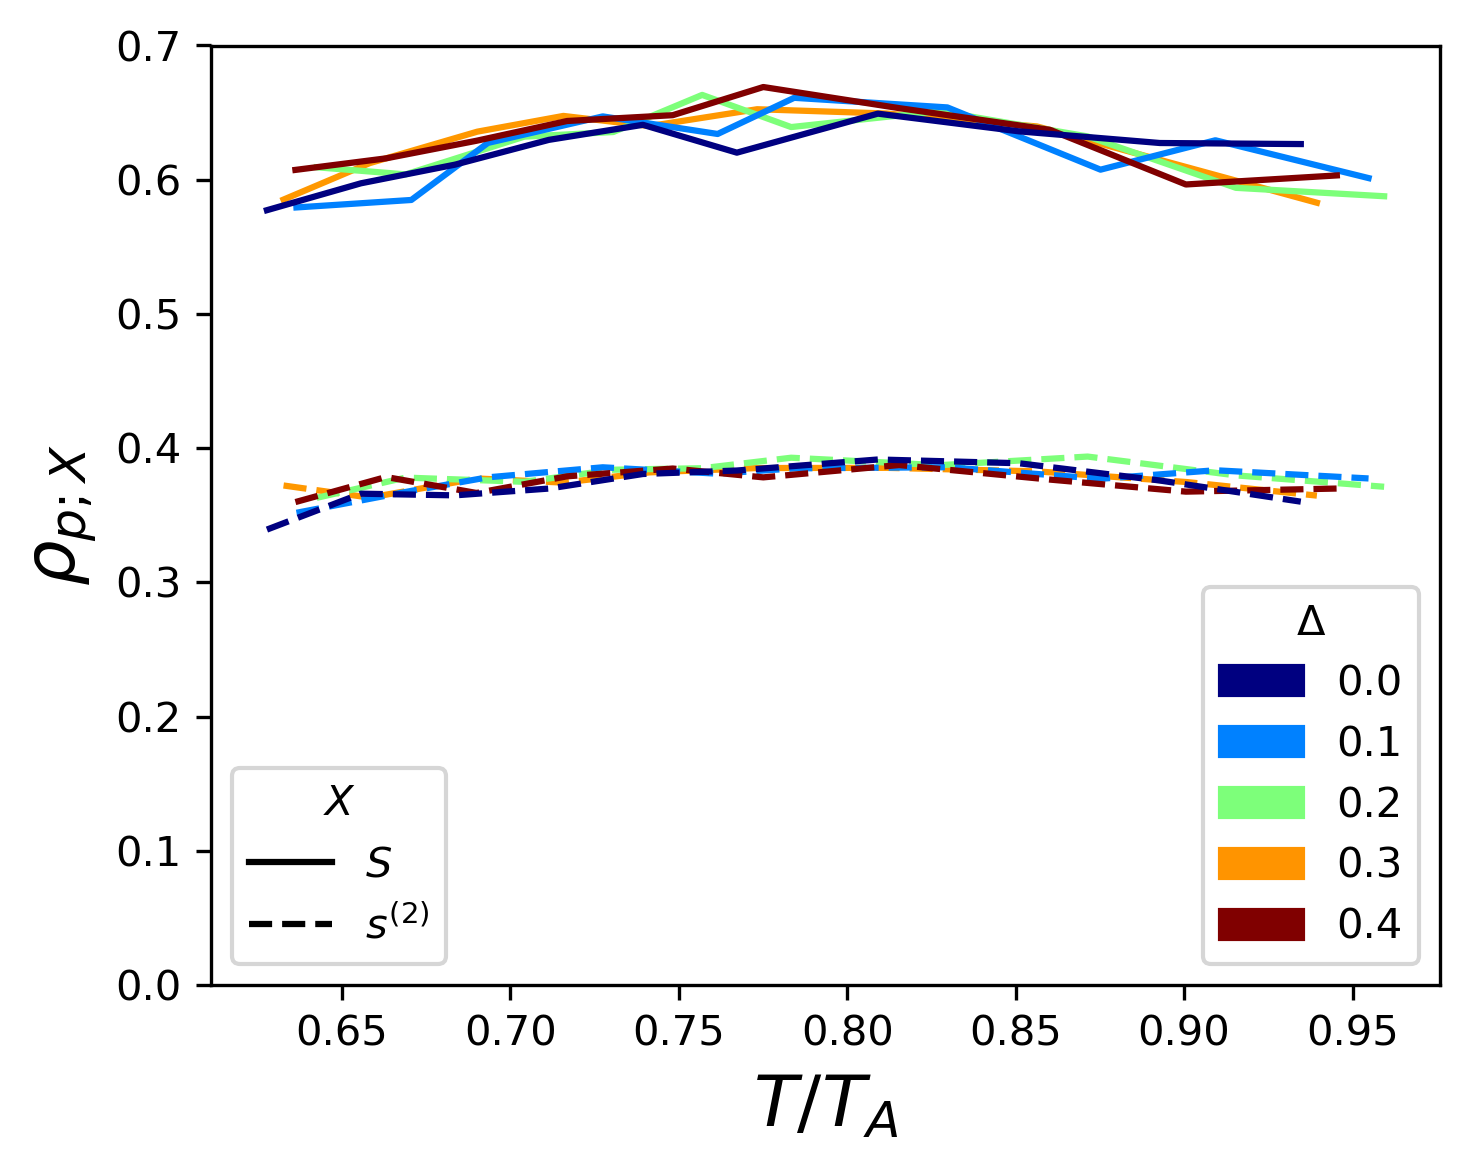

In [41]:
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.4)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

for job in project.find_jobs({"replica": 0, "delta": {"$ne": 0.5}}):

    delta = job.sp["delta"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    color = cmap(norm(delta))
    corrs = sorted(glob.glob(job.fn("short_runs/temp-*/fire_isconfig_corr.parquet")))
    softs = []
    simp_entr = []
    entrs = []
    entrs_svr = []
    temps = []
    for corr in corrs:
        temp = float(utils.extract_between(corr, "temp-", "/"))
        temps.append(temp)
        c = pd.read_parquet(corr)
        s = c.iloc[:,-1]
        softs.append(s.iloc[0])
        simp_entr.append(s.iloc[2])
        entrs.append(s.iloc[3])
        entrs_svr.append(s.iloc[4])
    plt.plot(temps/T_a, softs, color=color)
    # plt.plot(temps/np.max(temps), simp_entr)
    plt.plot(temps/T_a, entrs, color=color, linestyle="--")
    # plt.plot(temps/T_a, entrs_svr, color=color, linestyle=":")
    # break

lines = [plt.Line2D([0], [0], color="k"), plt.Line2D([0], [0], color="k", linestyle="--")]
# lines = [plt.Line2D([0], [0], color=cmap(norm(0.0))), plt.Line2D([0], [0], color=cmap(norm(0.1))), plt.Line2D([0], [0], color=cmap(norm(0.2))), plt.Line2D([0], [0], color=cmap(norm(0.3))), plt.Line2D([0], [0], color=cmap(norm(0.4)))]
# plt.legend(lines, [r"$\delta=0.0$", r"$\delta=0.1$", r"$\delta=0.2$", r"$\delta=0.3$", r"$\delta=0.4$"], fontsize=20)

plt.ylim(0, 0.7)
plt.ylabel(r"$\rho_{p;X}$")
plt.xlabel(r"$T/T_A$")

deltas = np.linspace(0.0, 0.4, 5)
color = list(cmap(norm(deltas)))
patches = []
for i in range(len(color)):
    patches.append(mpl.patches.Patch(color=color[i], label=f"{deltas[i]:.1f}"))

legend1 = plt.legend(handles=patches, loc=4, title=r"$\Delta$")
plt.gca().add_artist(legend1)

plt.legend(lines, [r"$S$", r"$s^{(2)}$"], title=r"$\it{X}$")

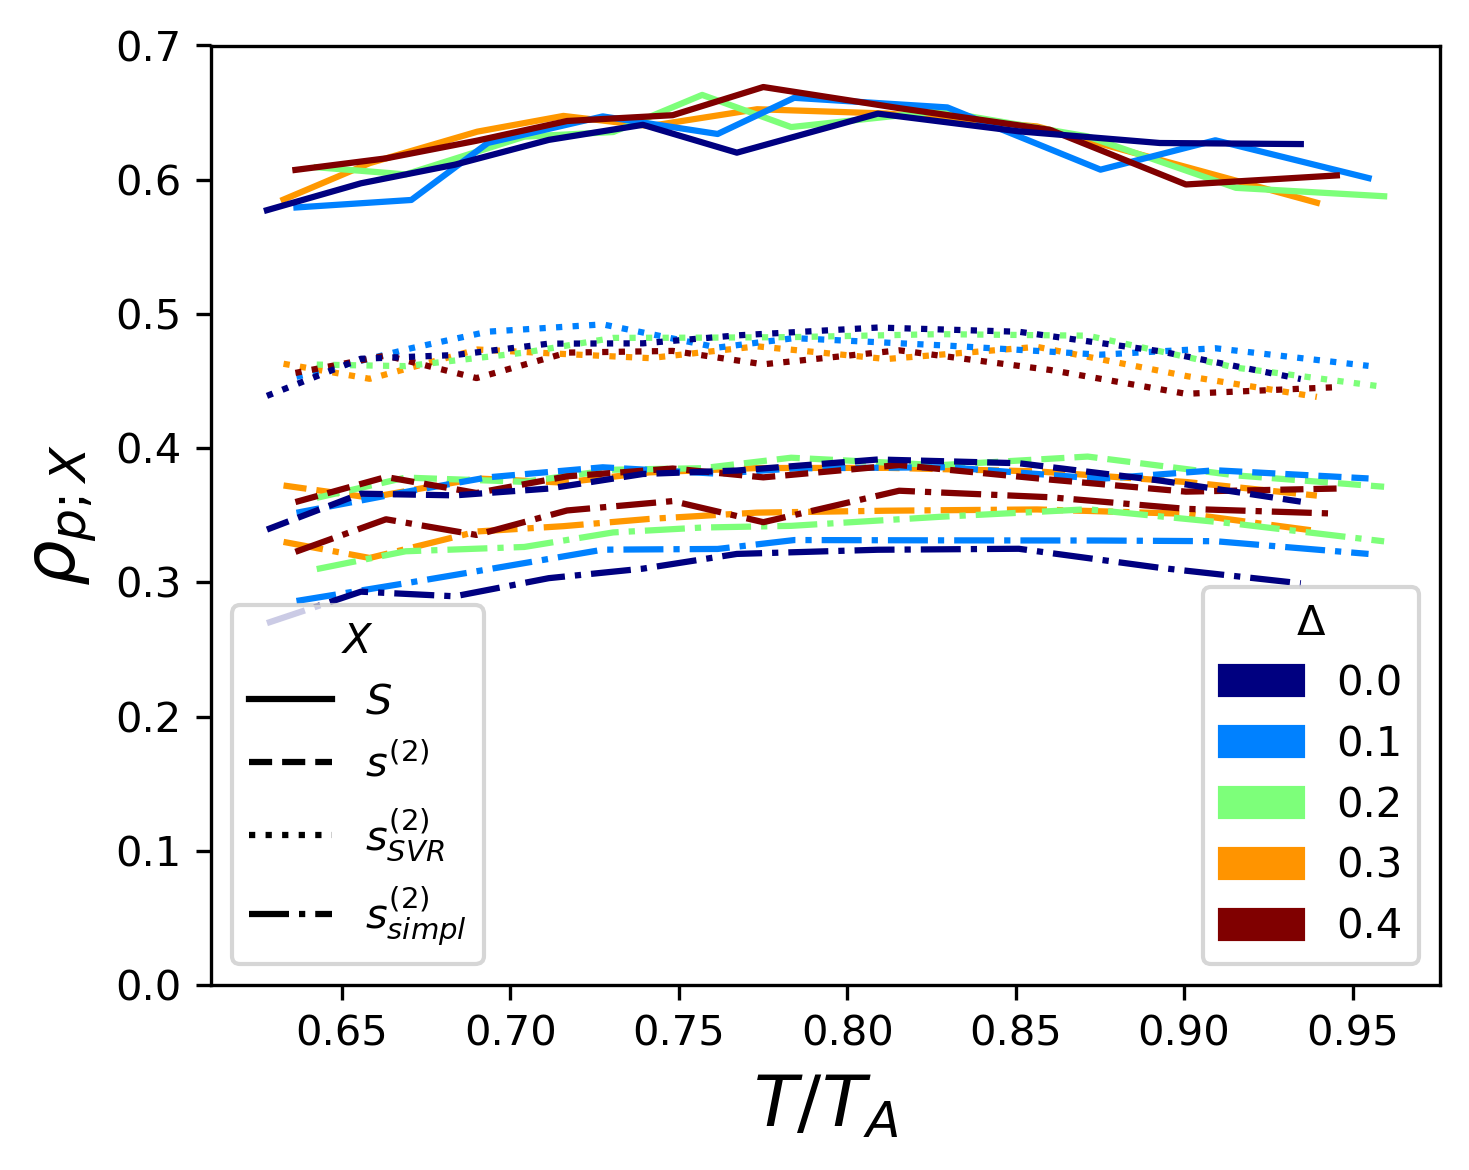

In [40]:
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.4)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

for job in project.find_jobs({"replica": 0, "delta": {"$ne": 0.5}}):

    delta = job.sp["delta"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())

    color = cmap(norm(delta))
    corrs = sorted(glob.glob(job.fn("short_runs/temp-*/fire_isconfig_corr.parquet")))
    softs = []
    simp_entr = []
    entrs = []
    entrs_svr = []
    temps = []
    for corr in corrs:
        temp = float(utils.extract_between(corr, "temp-", "/"))
        temps.append(temp)
        c = pd.read_parquet(corr)
        s = c.iloc[:,-1]
        softs.append(s.iloc[0])
        simp_entr.append(s.iloc[2])
        entrs.append(s.iloc[3])
        entrs_svr.append(s.iloc[4])
    plt.plot(temps/T_a, softs, color=color)
    plt.plot(temps/T_a, simp_entr, color=color, linestyle="-.")
    plt.plot(temps/T_a, entrs, color=color, linestyle="--")
    plt.plot(temps/T_a, entrs_svr, color=color, linestyle=":")
    # break

lines = [plt.Line2D([0], [0], color="k"), plt.Line2D([0], [0], color="k", linestyle="--"),
         plt.Line2D([0], [0], color="k", linestyle=":"),
         plt.Line2D([0], [0], color="k", linestyle="-.")]
# lines = [plt.Line2D([0], [0], color=cmap(norm(0.0))), plt.Line2D([0], [0], color=cmap(norm(0.1))), plt.Line2D([0], [0], color=cmap(norm(0.2))), plt.Line2D([0], [0], color=cmap(norm(0.3))), plt.Line2D([0], [0], color=cmap(norm(0.4)))]
# plt.legend(lines, [r"$\delta=0.0$", r"$\delta=0.1$", r"$\delta=0.2$", r"$\delta=0.3$", r"$\delta=0.4$"], fontsize=20)

plt.ylim(0, 0.7)
plt.ylabel(r"$\rho_{p;X}$")
plt.xlabel(r"$T/T_A$")

deltas = np.linspace(0.0, 0.4, 5)
color = list(cmap(norm(deltas)))
patches = []
for i in range(len(color)):
    patches.append(mpl.patches.Patch(color=color[i], label=f"{deltas[i]:.1f}"))

legend1 = plt.legend(handles=patches, loc=4, title=r"$\Delta$")
plt.gca().add_artist(legend1)

plt.legend(lines, [r"$S$", r"$s^{(2)}$", r"$s^{(2)}_{SVR}$",
                   r"$s^{(2)}_{simpl}$"], title=r"$\it{X}$", loc=3)